# Prêt à dépenser : Construire un modèle de scoring


## Contexte

"Prêt à dépenser" (Home Credit) est une société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.
Pour accorder un crédit à la consommation, l'entreprise calcule la probabilité qu'un client le rembourse, ou non. Elle souhaite donc développer un algorithme de scoring pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs du modèle de scoring. Puisqu'ils s'adressent aux clients, ils ont besoin que votre modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d'une mesure de l'importance des variables qui ont poussé le modèle à donner cette probabilité à un client.


## Chargement des modules du projet

Afin de simplifier le Notebook, le code métier du projet est placé dans le répertoire [src/](../src/).


In [1]:
# Import project modules from source directory

# system modules
import os
import sys

# Append source directory to system path
src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

# helper functions
import data.helpers as data_helpers
import features.helpers as feat_helpers
import visualization.helpers as vis_helpers


Nous allons utiliser le langage [Python](https://www.python.org/about/gettingstarted/), et présenter ici le code, les résultats et l'analyse sous forme de [Notebook JupyterLab](https://jupyterlab.readthedocs.io/en/stable/getting_started/overview.html).

Nous allons aussi utiliser les bibliothèques usuelles d'exploration et analyse de données, afin d'améliorer la simplicité et la performance de notre code :
  * [NumPy](https://numpy.org/doc/stable/user/quickstart.html) et [Pandas](https://pandas.pydata.org/docs/user_guide/index.html) : effectuer des calculs scientifiques (statistiques, algèbre, ...) et manipuler des séries et tableaux de données volumineuses et complexes
  * [scikit-learn](https://scikit-learn.org/stable/getting_started.html) et [XGBoost](https://xgboost.readthedocs.io/en/latest/get_started.html) : pour effectuer des analyses prédictives 
  * [Matplotlib](https://matplotlib.org/stable/tutorials/introductory/usage.html), [Pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html), [Seaborn](https://seaborn.pydata.org/tutorial/function_overview.html) et [Plotly](https://plotly.com/python/getting-started/) : générer des graphiques lisibles, intéractifs et pertinents


In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.model_selection import train_test_split
import xgboost as xgb

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Accelerate the development cycle
SAMPLE_FRAC: float = 1

# Prevent excessive memory usage used by plotly
DRAW_PLOTS: bool = False


## Chargement des données

Les données mises à disposition sont issues de [Home Credit](https://www.homecredit.net/) et plus précisément de la compétition hébergée sur Kaggle [Home Credit Default Risk - Can you predict how capable each applicant is of repaying a loan?](https://www.kaggle.com/c/home-credit-default-risk)

Les données sont fournies sous la forme de plusieurs fichiers CSV pouvant être liés entre eux de la manière suivante :

![Home Credit data relations](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

_source : [Introduction: Home Credit Default Risk Competition](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction) by [Will Koehrsen](https://www.kaggle.com/willkoehrsen)_


In [3]:
# Download and extract the raw data
data_helpers.download_extract_zip(
    zip_file_url="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip",
    files_names=(
        "application_test.csv",
        "application_train.csv",
        "bureau_balance.csv",
        "bureau.csv",
        "credit_card_balance.csv",
        "installments_payments.csv",
        "POS_CASH_balance.csv",
        "previous_application.csv",
    ),
    target_path="../data/raw/",
)


Nous allons charger toutes les données du fichier `application_train.csv` afin de travailler préparer les données du jeu d'entraînement et de test (variable `TARGET` vaut `O` : le client n'a pas fait défaut ou `1` : le client a fait défaut). Nous les séparerons les jeux de données au moment de l'entraînement et évaluation de nos modèles.

Les fichiers contiennent un grand nombre de variables booléennes et catégorielles que nous pouvons déjà typer comme telles.


In [4]:
# Read column names
application_train_column_names = pd.read_csv(
    "../data/raw/application_train.csv", nrows=0
).columns.values

# TARGET variable must be present in the Train datase
if "TARGET" not in application_train_column_names:
    raise ValueError(
        "TARGET column not found in application_train.csv. Please check that the file is not corrupted."
    )

# SK_ID_CURR variable must be present in the Train datase
if "SK_ID_CURR" not in application_train_column_names:
    raise ValueError(
        "SK_ID_CURR column not found in application_train_column_names.csv. Please check that the file is not corrupted."
    )

# Set column types according to fields description (../data/raw/HomeCredit_columns_description.csv)
# Categorical variables
column_types = {
    col: "category"
    for col in application_train_column_names
    if col.startswith(("NAME_",))
    or col.endswith(("_TYPE"))
    or col
    in [
        "CODE_GENDER",
        "WEEKDAY_APPR_PROCESS_START",
        "FONDKAPREMONT_MODE",
        "HOUSETYPE_MODE",
        "WALLSMATERIAL_MODE",
        "EMERGENCYSTATE_MODE",
    ]
}
# Boolean variables
column_types |= {
    col: bool
    for col in application_train_column_names
    if col.startswith(("FLAG_", "REG_", "LIVE_"))
}

# Load application data
app_df = pd.read_csv(
    "../data/raw/application_train.csv",
    dtype=column_types,
    true_values=["Y", "Yes", "1"],
    false_values=["N", "No", "0"],
    na_values=["XNA"], # bad values
)

# Sample to speed up development
if  float == type(SAMPLE_FRAC) and 0 < SAMPLE_FRAC < 1:
    app_df = app_df.sample(frac=SAMPLE_FRAC)

# Let's display basic statistical info about the data
app_df.describe(include="all")


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307507,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,...,307511,307511,307511,307511,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,2,2,2,NaN,NaN,NaN,NaN,...,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,F,False,True,NaN,NaN,NaN,NaN,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,278232,202448,202924,213312,NaN,NaN,NaN,NaN,...,305011,307328,307355,307408,NaN,NaN,NaN,NaN,NaN,NaN
mean,278180.518577,0.080729,NaN,NaN,NaN,NaN,0.417052,1.687979e+05,5.990260e+05,27108.573909,...,NaN,NaN,NaN,NaN,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,NaN,NaN,NaN,NaN,0.722121,2.371231e+05,4.024908e+05,14493.737315,...,NaN,NaN,NaN,NaN,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.700000e+05,16524.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.471500e+05,5.135310e+05,24903.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,NaN,NaN,NaN,NaN,1.000000,2.025000e+05,8.086500e+05,34596.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


In [5]:
app_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: bool(34), category(14), float64(65), int64(9)
memory usage: 187.7 MB


Le jeu de données contient 122 variables, dont la variable cible que nous devons estimer : `TARGET`. Parmis ces variables, nous avons :
- 34 variables booléennes
- 14 variables catégorielles
- 74 variables numériques

## Analyse exploratoire

Nous allons analyser la distribution de quelques variables.

### Variable cible

Voyons spécifiquement la distribution de la variable `TARGET` qui est celle que nous devrons estimer par la suite.
Les valeurs nulles représentent notre jeu d'entrainement.
Nous pouvons oberver que nous avons à faire à un problème de __classification binaire déséquilibré__ (il y a deux valeurs possibles, mais les deux valeurs ne sont pas également représentées).
Ceci va influencer la manière dont nous allons construire et entraîner notre modèle.


In [6]:
# Let's plot the distribution of the TARGET variable
if DRAW_PLOTS:
    fig = px.bar(
        app_df["TARGET"].replace({
            "0": "TARGET=0 : payments OK", 
            "1": "TARGET=1 : payment difficulties", 
        }).value_counts(),
        title="Distribution of TARGET variable",
        width=800,
        height=400,
    ).update_xaxes(
        title="TARGET",
    ).update_yaxes(title="Count")
    fig.show()


### Valeurs vides

Nous voyons que toutes les variables ont moins de 30% de valeurs vides, et près de la moitié a moins de 1% de valeurs vides. Le jeu de données est donc relativement bien rempli, ce qui ne devrait pas poser de problème pour la suite.


In [7]:
# Let's display variables with missing values ratio
if DRAW_PLOTS:
    vis_helpers.plot_empty_values(app_df)


### Valeurs impossibles

Quelques valeurs présentes dans les données semblent impossibles. Nous allons supprimer ces "outliers".


In [8]:
# Define data constraints
data_constraints = {
    "DAYS_EMPLOYED": {"min": -35000, "max": 0,}, # max 100 years, only negative values
}

if DRAW_PLOTS:
    # Let's display box plots for variables with outliers
    vis_helpers.plot_boxes(app_df, plot_columns=data_constraints.keys(), categorical_column="TARGET")

# Remove values that are outside possible range
app_df = feat_helpers.drop_impossible_values(
    app_df, constraints=data_constraints,
)


### Variables quantitatives

Nous allons simplement afficher la distribution de quelques variables numériques. Nous voyons déjà que selon la valeur de TARGET, la distribution (moyenne) des variables peut être sensiblement différente.


In [9]:
# Draw the BoxPlots of some numeric columns, split per Target
if DRAW_PLOTS:
    vis_helpers.plot_boxes(app_df,
        plot_columns=[
            "AMT_INCOME_TOTAL",
            "AMT_CREDIT",
            "AMT_ANNUITY",
            "AMT_GOODS_PRICE",
            "DAYS_BIRTH",
            "DAYS_EMPLOYED",
            "OWN_CAR_AGE",
            "REGION_RATING_CLIENT",
            "REGION_RATING_CLIENT_W_CITY",
            "EXT_SOURCE_1",
            "EXT_SOURCE_2",
            "EXT_SOURCE_3",
            "DAYS_LAST_PHONE_CHANGE",
            "AMT_REQ_CREDIT_BUREAU_YEAR",
        ],
        categorical_column="TARGET",
    )


### Variables qualitatives

De la même manière, nous allons simplement afficher la distribution de quelques variables catégorielles. Nous voyons déjà que selon la valeur de TARGET, la distribution (répartition entre classes) des variables peut être sensiblement différente (`TARGET=0` pour 77,6% des `NAME_CONTRACT_TYPE="Cash loans"`, tandis que `TARGET=0` pour 93,1% des `NAME_CONTRACT_TYPE="Revolving loans"`).
Certaines variables ont une répartition très inégale entre classes (`FLAG_MOBIL` vaut systématiquement `True` et jamais `False`).


In [10]:
# Draw the Bar charts of some categorical columns, split per Target
if DRAW_PLOTS:
    vis_helpers.plot_categories_bars(app_df,
        plot_columns=[
            "NAME_CONTRACT_TYPE",
            "CODE_GENDER",
            "FLAG_OWN_CAR",
            "FLAG_OWN_REALTY",
            "NAME_INCOME_TYPE",
            "NAME_EDUCATION_TYPE",
            "NAME_FAMILY_STATUS",
            "NAME_HOUSING_TYPE",
            "OCCUPATION_TYPE",
            "FLAG_MOBIL",
        ],
        categorical_column="TARGET",
    )


### Encodage des catégories

Lorsque les données qualitatives ne sont pas ordinales (on ne peu pas les classer selon un certain ordre), l'encodage "One Hot Encoding" sera plus performant que le "Label Encoding".


In [11]:
# Encode categorical variables with One Hot Encoding
app_df = pd.get_dummies(app_df, dtype=bool)

app_df.describe(include="bool")


,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
count,252137,252137,252137,252137,252137,252137,252137,252137,252137,252137,...,252137,252137,252137,252137,252137,252137,252137,252137,252137,252137
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,True,True,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
freq,157719,171082,252136,252125,190830,251601,182123,236126,247790,236525,...,251130,244626,250217,250616,250778,197798,198699,247695,131341,250191


Nous avons ici créé 134 nouvelles variables booléennes qui correspondent aux différentes classes de chacune des 14 anciennes variables catégorielles qui ont été encodées et supprimées.


## Feature Engineering

Nous allons tenter d'enrichir nos données en intégrant des variables qui sont des compositions non linéaires des variables existantes.


### Données métier

Afin d'apporter plus de sens aux données que nous allons fournir à nos modèles, nous pouvons faire appel aux experts métier qui peuvent nous indiquer des informations qui sont réputées importantes afin de prédire si un client risque d'avoir des problèmes de remboursement ou non.

Les informations métier pertinentes sont :
- Montant emprunté / Prix du bien acheté : `AMT_CREDIT / AMT_GOODS_PRICE`
- Montant des annuités / Montant emprunté : `AMT_ANNUITY / AMT_CREDIT`
- Montant des annuités / Revenu annuel : `AMT_ANNUITY / AMT_INCOME_TOTAL`
- Ancienneté au travail / Age : `DAYS_EMPLOYED / DAYS_BIRTH`


In [12]:
# Create the new features
app_df["CREDIT_PRICE_RATIO"] = app_df["AMT_CREDIT"] / app_df["AMT_GOODS_PRICE"]
app_df["ANNUITY_CREDIT_RATIO"] = app_df["AMT_ANNUITY"] / app_df["AMT_CREDIT"]
app_df["ANNUITY_INCOME_RATIO"] = app_df["AMT_ANNUITY"] / app_df["AMT_INCOME_TOTAL"]
app_df["EMPLOYED_BIRTH_RATIO"] = app_df["DAYS_EMPLOYED"] / app_df["DAYS_BIRTH"]

# Draw the BoxPlots for these features
if DRAW_PLOTS:
    vis_helpers.plot_boxes(app_df,
        plot_columns=[
            "CREDIT_PRICE_RATIO",
            "ANNUITY_CREDIT_RATIO",
            "ANNUITY_INCOME_RATIO",
            "EMPLOYED_BIRTH_RATIO",
        ],
        categorical_column="TARGET",
    )


### Composition polynomiales de variables existantes

Les variables `EXT_SOURCE_{1-3}` n'ont a priori pas de sens concret. On peut imaginer que `TARGET` ne soit pas forcément linéairement dépendant de ces variables. Nous allons donc générer des combinaisons polynomiales de ces variables.


In [13]:
from sklearn.preprocessing import PolynomialFeatures


# Let's keep only non null data
ext_source = app_df[["SK_ID_CURR", "TARGET", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].dropna()

# Let's create the new features
poly = PolynomialFeatures()
poly_feat = pd.DataFrame(poly.fit_transform(
        X=ext_source[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]],
        y=ext_source["TARGET"],
    )
)
poly_feat.columns=poly.get_feature_names()

poly_feat.insert(0, "SK_ID_CURR", ext_source["SK_ID_CURR"].values)

# Merge the new features with the original dataset
app_df = app_df.merge(
    poly_feat,
    on="SK_ID_CURR",
    how="left",
)

# Draw the BoxPlots for these features
if DRAW_PLOTS:
    vis_helpers.plot_boxes(app_df,
        plot_columns=poly_feat.columns[5:],
        categorical_column="TARGET",
    )


### Features selection

Le but ici est d'éliminer un certain nombre de variables afin d'accélérer l'entrainement et la prédiction de nos modèles. Nous souhaitons éliminer les variables qui pénaliseront le moins possible les performances de nos modèles.

Nous savons déjà que les colonnes `SK_ID_CURR` (simple identifiant sans sens métier), `1` et `x{0-2}` (variables polynomiales d'ordre 0 et 1), et `FLAG_MOBIL` (vaut toujours 1) n'apportent pas d'information. Nous allons donc les éliminer.

In [14]:
# Let's drop the features that are not useful for the prediction
app_df = app_df.drop(
    columns=["SK_ID_CURR", "1", "x0", "x1", "x2", "FLAG_MOBIL"]
)


Nous allons ici observer la corrélation :
- de chaque variable avec la variables cible `TARGET` : les variables les moins corrélées à `TARGET` seront a priori les moins utiles pour prédire sa valeur.
- entre les différentes variables deux à deux : si deux variables sont très corrélées, elles apportent une information redondante et nous pouvons donc en éliminer une des deux.


In [15]:
# Let's compute the correlation matrix
app_correlations = app_df.corr().abs().sort_values(
    "TARGET", ascending=False, axis=0
).sort_values(
    "TARGET", ascending=False, axis=1
)

if DRAW_PLOTS:
    fig = px.imshow(app_correlations,
        title="Correlations between features",
        width=1200,
        height=1200,
    )
    fig.show()


Nous voyons qu'il y a des variables très peu corrélées à `TARGET` (ex. : `abs(corr("TARGET", "FLAG_EMP_PHONE")) < 0.0001`), et d'autres très corrélées entre elles (ex. : `abs(corr("LIVINGAPARTMENTS_AVG", ""LIVINGAPARTMENTS_MEDI")) > 0.99`).
Nous allons simplifier notre jeu de données en supprimant ces variables.


In [16]:
# Let's find variables that are highly de-correlated from TARGET
corr_target_min_threshold = 0.01
highly_decorrelated_from_target = pd.DataFrame(columns=["correlation with TARGET"])
for col in app_correlations.columns:
    if col != "TARGET" and (
        pd.isnull(app_correlations[col]["TARGET"])
        or abs(app_correlations[col]["TARGET"]) < corr_target_min_threshold
    ):
        highly_decorrelated_from_target.loc[col] = {
            "correlation with TARGET": app_correlations[col]["TARGET"],
        }

highly_decorrelated_from_target.sort_values(by=["correlation with TARGET"])


,correlation with TARGET
ORGANIZATION_TYPE_Industry: type 11,0.000023
FLAG_EMP_PHONE,0.000080
NAME_EDUCATION_TYPE_Incomplete higher,0.000223
FLAG_DOCUMENT_20,0.000241
ORGANIZATION_TYPE_Trade: type 1,0.000328
...,...
ORGANIZATION_TYPE_Kindergarten,0.009678
YEARS_BEGINEXPLUATATION_MODE,0.009697
ORGANIZATION_TYPE_University,0.009729
OCCUPATION_TYPE_Cooking staff,0.009858


In [17]:
# Let's find variables that have a highly correlated pair
corr_pair_max_threshold = 0.9
highly_correlated = pd.DataFrame(columns=["pair", "correlation"])
for i in range(len(app_correlations.columns)):
    for j in range(i + 1, len(app_correlations.columns)):
        if app_correlations.iloc[i, j] > corr_pair_max_threshold:
            # variables are highly correlated
            if app_correlations.iloc[0, i] > app_correlations.iloc[0, j]:
                # first variable is more correlated with target => we want to keep it
                keep_index = i
                drop_index = j
            else:
                keep_index = j
                drop_index = i

            highly_correlated.loc[app_correlations.columns[drop_index]] = {
                "pair": app_correlations.columns[keep_index],
                "correlation": app_correlations.iloc[i, j],
            }

highly_correlated.sort_values(by="correlation", ascending=False)


,pair,correlation
NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_Cash loans,1.000000
CODE_GENDER_F,CODE_GENDER_M,0.999966
YEARS_BUILD_AVG,YEARS_BUILD_MEDI,0.998625
OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.998473
FLOORSMIN_MEDI,FLOORSMIN_AVG,0.997280
FLOORSMAX_MEDI,FLOORSMAX_AVG,0.997094
ENTRANCES_MEDI,ENTRANCES_AVG,0.996868
COMMONAREA_AVG,COMMONAREA_MEDI,0.996439
ELEVATORS_MEDI,ELEVATORS_AVG,0.996105
LIVINGAREA_MEDI,LIVINGAREA_AVG,0.995623


In [18]:
# Drop irrelevant columns
app_df.drop(
    columns=highly_decorrelated_from_target.index,
    inplace=True,
    errors="ignore",
)
app_df.drop(
    columns=highly_correlated.index,
    inplace=True,
    errors="ignore",
)

app_df.describe(include="all")


,TARGET,FLAG_OWN_CAR,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",EMERGENCYSTATE_MODE_No,CREDIT_PRICE_RATIO,ANNUITY_CREDIT_RATIO,ANNUITY_INCOME_RATIO,x0 x1,x0 x2,x1 x2
count,252137.000000,252137,252125.000000,2.518810e+05,252137.000000,252137.000000,252137.000000,252137.000000,252137.000000,94413.000000,...,252137,252137,252137,252137,251881.000000,252125.000000,252125.000000,9.896300e+04,98963.000000,9.896300e+04
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,157719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,250616,197798,198699,131341,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.086600,NaN,27812.325168,5.494057e+05,0.020894,-14769.133174,-2384.169325,-4635.430849,-2800.639724,11.950187,...,NaN,NaN,NaN,NaN,1.123500,0.053892,0.177266,2.667788e-01,0.246540,2.643175e-01
std,0.281248,NaN,14647.759104,3.732685e+05,0.013874,3662.573769,2338.360162,3252.169156,1515.360629,11.981952,...,NaN,NaN,NaN,NaN,0.126625,0.022521,0.090983,1.558798e-01,0.152676,1.452604e-01
min,0.000000,NaN,1980.000000,4.050000e+04,0.000290,-25200.000000,-17912.000000,-22928.000000,-7197.000000,0.000000,...,NaN,NaN,NaN,NaN,0.150000,0.022073,0.000224,5.740538e-07,0.000014,3.255191e-07
25%,0.000000,NaN,17073.000000,2.475000e+05,0.010006,-17563.000000,-3175.000000,-6952.000000,-4177.000000,5.000000,...,NaN,NaN,NaN,NaN,1.000000,0.037060,0.112500,1.397380e-01,0.123250,1.466391e-01
50%,0.000000,NaN,25834.500000,4.500000e+05,0.018850,-14573.000000,-1648.000000,-4265.000000,-2886.000000,9.000000,...,NaN,NaN,NaN,NaN,1.118800,0.050000,0.160333,2.514975e-01,0.223662,2.585384e-01
75%,0.000000,NaN,35617.500000,6.930000e+05,0.028663,-11775.000000,-767.000000,-1845.000000,-1487.000000,15.000000,...,NaN,NaN,NaN,NaN,1.198000,0.064314,0.224960,3.803050e-01,0.349307,3.744008e-01


Après simplification, nous voyons que nous avons drastiquement réduit le nombre de variables pour ne conserver que celles réellement pertinentes pour la prédiction de `TARGET`.


## Préparation des données

Nous allons transformer les données pour que nos modèles puissent les exploiter au mieux. Afin d'éviter la "fuite d'information" entre le jeu de données d'entraînement et de test, nous allons maintenant séparer notre jeu de données en deux. Les transformations seront apprises uniquement sur le jeu d'entraînement, mais appliquées aux deux jeux de données (entraînement et test).


In [25]:
# Given data
X = app_df.drop(["TARGET"], axis=1)
# Data to predict
y = app_df["TARGET"]

# Let's split the whole dataset into a training set (80% of data) and a test set (20% of data)
# The dataset will be split in a stratified way, in order to have a good distribution of the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y , random_state=42)


### Normalisation des données

Afin d'éviter que certains modèles pondèrent l'importance de certaines variables à cause de leur ordre de grandeur, nous allons normaliser chaque variable afin de les ramener à une moyenne nulle et une variance de 1.


In [26]:
# Scale each variable of the DataFrame
from sklearn.preprocessing import StandardScaler

# define scaler
scaler = StandardScaler()

# fit scaler on train data only, to avoid data leak
X_train = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X.columns,
)
X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X.columns,
)

X_train.describe(include="all")


,FLAG_OWN_CAR,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",EMERGENCYSTATE_MODE_No,CREDIT_PRICE_RATIO,ANNUITY_CREDIT_RATIO,ANNUITY_INCOME_RATIO,x0 x1,x0 x2,x1 x2
count,2.017090e+05,2.016990e+05,2.015040e+05,2.017090e+05,2.017090e+05,2.017090e+05,2.017090e+05,2.017090e+05,7.553400e+04,2.017090e+05,...,2.017090e+05,2.017090e+05,2.017090e+05,2.017090e+05,2.015040e+05,2.016990e+05,2.016990e+05,7.908000e+04,7.908000e+04,7.908000e+04
mean,4.379921e-15,-5.780894e-17,-1.287073e-16,-9.328319e-18,3.064068e-17,-1.134859e-17,2.100798e-17,-9.296176e-17,-5.732981e-16,6.603411e-15,...,-3.917992e-16,-5.594636e-15,2.105532e-15,-2.368642e-15,-1.264926e-15,-5.198424e-17,-2.486383e-16,-4.992073e-17,1.722179e-16,6.734483e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000007e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-7.737541e-01,-1.761855e+00,-1.351575e+00,-1.484581e+00,-2.848743e+00,-6.509712e+00,-5.554364e+00,-2.474930e+00,-9.993036e-01,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,-1.042885e+00,-7.652617e+00,-1.412660e+00,-1.945859e+00,-1.709705e+00,-1.616246e+00,-1.819401e+00
25%,-7.737541e-01,-7.326865e-01,-8.086297e-01,-7.842192e-01,-7.623051e-01,-3.387911e-01,-7.121395e-01,-9.084423e-01,-5.807767e-01,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,-1.042885e+00,-9.713977e-01,-7.474075e-01,-7.114522e-01,-8.163247e-01,-8.058500e-01,-8.087277e-01
50%,-7.737541e-01,-1.342828e-01,-2.656849e-01,-1.467140e-01,5.485125e-02,3.151749e-01,1.118596e-01,-5.621510e-02,-2.459553e-01,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,9.588784e-01,-3.759905e-02,-1.730343e-01,-1.870201e-01,-9.628230e-02,-1.508959e-01,-4.228270e-02
75%,1.292400e+00,5.298255e-01,3.858489e-01,5.606400e-01,8.168571e-01,6.911947e-01,8.586856e-01,8.666460e-01,2.562769e-01,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,9.588784e-01,5.849334e-01,4.622681e-01,5.240965e-01,7.264475e-01,6.726754e-01,7.602456e-01
max,1.292400e+00,1.570791e+01,9.386668e+00,3.721135e+00,1.986759e+00,1.020533e+00,1.425339e+00,1.849579e+00,6.617884e+00,1.763510e+00,...,1.290474e+01,1.906111e+00,1.929044e+00,9.588784e-01,3.832989e+01,3.130703e+00,1.401081e+01,2.989431e+00,3.554755e+00,2.982891e+00


Nous avons ici équilibré les ordres de grandeur de chaque variables, afin que nos futurs modèles ne soient pas influencés par leur différence.


### Imputation des valeurs manquantes

Afin d'éviter que certains modèles ne puissent être utilisés à cause des valeurs manquantes, nous allons remplacer toutes les valeurs nulles par leur meilleure estimation possible.


In [27]:
# Impute missing values by modeling each feature with missing values as a function of other features in a round-robin fashion
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

if os.path.exists("../data/processed/X_train_imputed.csv") and os.path.exists("../data/processed/X_test_imputed.csv"):
    X_train = pd.read_csv("../data/processed/X_train_imputed.csv")
    X_test = pd.read_csv("../data/processed/X_test_imputed.csv")
else:
    # define imputer
    imputer = IterativeImputer(
        n_nearest_features=min(5, int(len(X.columns) / 10)),
    )

    # fit imputer on train data only, to avoid data leak
    X_train = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X.columns,
    )
    X_test = pd.DataFrame(
        imputer.transform(X_test),
        columns=X.columns,
    )

    # Save the processed data
    X_train.to_csv("../data/processed/X_train_imputed.csv", index=False)
    X_test.to_csv("../data/processed/X_test_imputed.csv", index=False)

X_train.describe(include="all")


,FLAG_OWN_CAR,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",EMERGENCYSTATE_MODE_No,CREDIT_PRICE_RATIO,ANNUITY_CREDIT_RATIO,ANNUITY_INCOME_RATIO,x0 x1,x0 x2,x1 x2
count,2.017090e+05,2.017090e+05,201709.000000,2.017090e+05,2.017090e+05,2.017090e+05,2.017090e+05,2.017090e+05,201709.000000,2.017090e+05,...,2.017090e+05,2.017090e+05,2.017090e+05,2.017090e+05,201709.000000,2.017090e+05,201709.000000,201709.000000,201709.000000,201709.000000
mean,4.379921e-15,-7.225982e-07,-0.000115,-1.391542e-17,2.831135e-17,-1.534731e-17,1.651005e-17,-9.386112e-17,-0.000016,6.603411e-15,...,-3.910717e-16,-5.594636e-15,2.106175e-15,-2.368642e-15,-0.000956,4.136604e-08,-0.000003,-0.044755,0.007856,-0.027881
std,1.000002e+00,9.999858e-01,0.999522,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.615185,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.999948,9.999781e-01,0.999981,0.835646,0.737523,0.925202
min,-7.737541e-01,-1.761855e+00,-1.351575,-1.484581e+00,-2.848743e+00,-6.509712e+00,-5.554364e+00,-2.474930e+00,-0.999304,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,-1.042885e+00,-7.652617,-1.412660e+00,-1.945859,-2.093773,-2.003836,-3.216198
25%,-7.737541e-01,-7.326865e-01,-0.808630,-7.842192e-01,-7.623051e-01,-3.387911e-01,-7.121395e-01,-9.084423e-01,-0.101455,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,-1.042885e+00,-0.971398,-7.474075e-01,-0.711452,-0.663293,-0.444729,-0.697841
50%,-7.737541e-01,-1.342828e-01,-0.265685,-1.467140e-01,5.485125e-02,3.151749e-01,1.118596e-01,-5.621510e-02,-0.023850,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,9.588784e-01,-0.037599,-1.730343e-01,-0.187020,0.016990,-0.005197,0.029888
75%,1.292400e+00,5.298255e-01,0.385849,5.606400e-01,8.168571e-01,6.911947e-01,8.586856e-01,8.666460e-01,0.078547,-5.670509e-01,...,-7.749089e-02,-5.246283e-01,-5.183915e-01,9.588784e-01,0.584933,4.622681e-01,0.524096,0.513117,0.399025,0.650363
max,1.292400e+00,1.570791e+01,9.386668,3.721135e+00,1.986759e+00,1.020533e+00,1.425339e+00,1.849579e+00,6.617884,1.763510e+00,...,1.290474e+01,1.906111e+00,1.929044e+00,9.588784e-01,38.329891,3.130703e+00,14.010811,2.989431,3.554755,2.982891


## Modélisation et évaluation des modèles

Nous allons ici entraîner différents modèles de classification binaire et évaluer leur efficacité selon trois critères :
- le **temps d'exécution** : temps nécessaire au modèle pour les phases d'apprentissage (`fit`) et de prédiction (`predict`).
- l'**interprétabilité** du modèle : la capacité du modèle à nous indiquer quelles sont les variables qui expliquent le mieux la prédiction.
- la **performance** : nous allons mesurer différentes métriques (`accuracy` = taux de prédictions positives ou négatives correctes, `precision` = taux de prédictions positives correctes, `recall` = taux de positifs correctement prédits, `F1 score` = moyenne harmonique de la `precision` et du `recall`) pour chaque modèle. Nous utiliserons le `F1 score` comme mesure principale de la performance, car nous sommes face à un problème où les deux classes de la variable prédite ne sont pas équilibrées (`TARGET=0 ~ 92%`) dans le jeu de données, et nous voulons maximiser en priorité le `recall` (bien prédire les problèmes de paiement). Nous tracerons les courbes de `Precision-Recall` et de `ROC (Receiver operating characteristic)` qui compare le `recall` au taux de faux positifs.

Afin d'améliorer la qualité du modèle et minimiser le biais de sélection du jeu d'entraînement, nous allons utiliser la méthode `StratifiedKFold` qui permet de "mixer" les résultats sur plusieurs sous-ensembles du jeu d'entraînement.

Afin de chercher les meilleurs hyper-paramètres de chacun des modèles, nous allons 

In [46]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Normalizer, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, RidgeClassifier, ElasticNet, LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    average_precision_score,
    auc,
)


## StratifiedKFold Cross Validator
# StratifiedKFold permet de séparer les données en nombre de folds de manière stratifiée.
# Les proportions des classes sont conservées.
grid_cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## F1 Score
# F1 Score permet de mesurer la qualité d'un modèle en évaluant la précision et le
# recall.
grid_scoring='f1'


### Modèle de référence

Nous allons utiliser un modèle bête et méchant qui se contente de faire des prédictions aléatoires, en respectant 

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 9
min_resources_: 20
max_resources_: 201709
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 20
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10085. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



----------

DummyClassifier(strategy='stratified')

----------

Best parameters set found on development set:
{'strategy': 'stratified'}

Training set score: 0.08868580624766503
Test set score: 0.07875813263326102

Grid scores on development set:
0.000 (+/-0.000) for {'strategy': 'stratified'}

Confusion matrix:
[[42139  3922]
 [ 4026   341]]

Detailed classification report:
                                 precision    recall  f1-score   support

         TARGET=0 : payments OK       0.91      0.91      0.91     46061
TARGET=0 : payment difficulties       0.08      0.08      0.08      4367

                       accuracy                           0.84     50428
                      macro avg       0.50      0.50      0.50     50428
                   weighted avg       0.84      0.84      0.84     50428




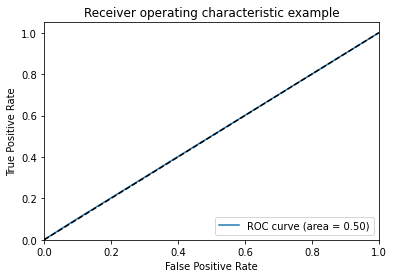

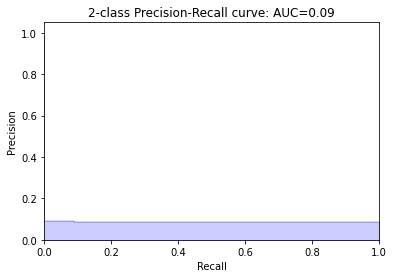

In [52]:
## Dummy Classifier
# DummyClassifier permet de faire des prédictions aléatoires.

grid = HalvingRandomSearchCV(
    estimator=DummyClassifier(),
    param_distributions={'strategy': ['stratified']},
    cv=grid_cv,
    scoring=grid_scoring,
    verbose=9,
    n_jobs=4,
).fit(
    X=X_train,
    y=y_train,
)


y_pred = grid.best_estimator_.predict(X_test)

print()
print("----------")
print()
print(grid.best_estimator_)

print()
print("----------")
print()
print("Best parameters set found on development set:")
print(grid.best_params_)
print()

print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_test, y_test)))
print()

print("Grid scores on development set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred,))
print()

print("Detailed classification report:")
print(classification_report(y_test, y_pred, 
    target_names={
        "TARGET=0 : payments OK",
        "TARGET=0 : payment difficulties",
    }
))
print()


y_true, y_pred_proba = y_test, grid.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = roc_auc_score(y_true, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)

plt.figure()
plt.step(recall, precision, color="b", alpha=0.2, where="post")
plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    "2-class Precision-Recall curve: AUC={0:0.2f}".format(ap)
)
plt.show()


In [48]:
# Linear Regression

# - On apprend les coefficients d'une régression linéaire en maximisant le log de la vraisemblance, où, de manière équivalente si l'on suppose l'erreur normalement distribuée et centrée en zéro, en minimisant la somme des carrés des erreurs.
# - Cette méthode s'appelle la méthode des moindres carrés.
# - Si la matrice  $\(X^\top X\)$ est inversible, la régression linéaire admet une solution unique et explicite.
# - Sinon, on peut calculer une solution grâce à un algorithme de calcul de pseudo-inverse, mais cette solution n'est pas unique.


# Variables must be :
# - linear relationship with target
# - i.i.d.
# - error is normally distributed
# - no outliers
# - no missing values
# - no multicollinearity
# - numeric (categorical variables must be encoded)

grid = HalvingRandomSearchCV(
    estimator=LinearRegression(),
    param_distributions={},
    cv=grid_cv,
    scoring=grid_scoring,
    verbose=9,
    n_jobs=4,
).fit(
    X=X_train,
    y=y_train,
)


y_pred = grid.predict(X_test)

print()
print("----------")
print()
print("Best parameters set found on development set:")
print(grid.best_params_)
print()

print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_test, y_test)))
print()

print("Grid scores on development set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred,))
print()

print("Detailed classification report:")
print(classification_report(y_test, y_pred, 
    target_names={
        "TARGET=0 : payments OK",
        "TARGET=0 : payment difficulties",
    }
))
print()


y_pred_proba = grid.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)

plt.figure()
plt.step(recall, precision, color="b", alpha=0.2, where="post")
plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    "2-class Precision-Recall curve: AP={0:0.2f}".format(ap)
)
plt.show()



n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 10
min_resources_: 10
max_resources_: 201709
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 10
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=20170. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the train scores are non-finite: [nan]
  warnings.warn(



----------

Best parameters set found on development set:
{}



ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
# Ridge Regression
# Prevents overfitting by penalizing the magnitude of coefficients with L2 regularization of the loss function

# - La norme ℓ2 du vecteur de poids peut être utilisée comme terme de régularisation de la régression linéaire.
# - Cela s'appelle la régularisation de Tykhonov, ou régression ridge.
# - La régression ridge admet toujours une solution analytique unique.
# - La régression ridge permet d'éviter le surapprentissage en restraignant l'amplitude des poids.
# - La régression ridge a un effet de sélection groupée : les variables corrélées ont le même coefficient.

grid = HalvingRandomSearchCV(
    estimator=RidgeClassifier(),
    param_distributions={
        'alpha': np.logspace(-3,7,50)
    },
    cv=grid_cv,
    scoring=grid_scoring,
    verbose=9,
    n_jobs=4,
).fit(
    X=X_train,
    y=y_train,
)


y_pred = grid.predict(X_test)

print()
print("----------")
print()
print("Best parameters set found on development set:")
print(grid.best_params_)
print()

print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_test, y_test)))
print()

print("Grid scores on development set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred,))
print()

print("Detailed classification report:")
print(classification_report(y_test, y_pred, 
    target_names={
        "TARGET=0 : payments OK",
        "TARGET=0 : payment difficulties",
    }
))
print()


y_pred_proba = grid.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)

plt.figure()
plt.step(recall, precision, color="b", alpha=0.2, where="post")
plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    "2-class Precision-Recall curve: AP={0:0.2f}".format(ap)
)
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV, StratifiedKFold

from sklearn.linear_model import RidgeCV
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    explained_variance_score,
)


clf = HalvingGridSearchCV(
    estimator=RidgeClassifier(),
    param_grid={
        'alpha': np.logspace(-3,7,50)
    },
    cv=grid_cv,
    scoring=grid_scoring,
    verbose=9,
    n_jobs=4,
).fit(
    X=X_train,
    y=y_train,
)


y_pred = clf.predict(X_test)

print(clf.best_params_)

print(
    f"Best score: {clf.score(X_test, y_test):.3f}, ",
    f"R2 score: {r2_score(y_test, y_pred):.3f}, "
    f"MSE: {mean_squared_error(y_test, y_pred):.3f}, "
    f"MAE: {mean_absolute_error(y_test, y_pred):.3f}, "
    f"EVS: {explained_variance_score(y_test, y_pred):.3f}"
)





---

# Annexe

Les Notebooks Kaggle [Introduction: Home Credit Default Risk Competition](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction) (et suivants) de [Will Koehrsen](https://www.kaggle.com/willkoehrsen) ont été d'une très grande aide dans l'exploration des données.
